In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [16]:
# Set parameters here 
INPUT_SIZE = 128
mapping = {0:'normal', 1:'abnormal'}
NUMCLASSES = len(mapping)

folder = r'C:\Users\arung\OneDrive\Desktop\COVID 19 Chest Xray\nih'

trainFolder = folder + r'\train'
valFolder = folder + r'\val'
testFolder = folder + r'\test'


In [17]:
from skimage.io import imread, imsave
from skimage.transform import resize

def make_labels(label):
    labels = np.zeros([NUMCLASSES],np.uint8)
    labels[label] = 1
    return labels
    
def train_data_with_label():
    train_images = []
    
    fileList1 = os.listdir(trainFolder + r'\normal')
    labels1 = np.zeros(len(fileList1),'uint8')
    fileList2 = os.listdir(trainFolder + r'\abnormal')
    labels2 = np.ones(len(fileList2),'uint8')
    train_x = np.array(fileList1 + fileList2)
    train_y = np.concatenate((labels1,labels2),axis=0)
    
    for fileNum in range(train_x.shape[0]):
        fileName = trainFolder + '\\' + mapping[train_y[fileNum]]+ '\\' + train_x[fileNum]
        label = train_y[fileNum]
        img = resize(imread(fileName),(INPUT_SIZE,INPUT_SIZE))
        train_images.append([img, make_labels(label)])
    np.random.shuffle(train_images)
    return train_images

def validation_data_with_label():
    validation_images = []
    
    fileList1 = os.listdir(valFolder + r'\normal')
    labels1 = np.zeros(len(fileList1),'uint8')
    fileList2 = os.listdir(valFolder + r'\abnormal')
    labels2 = np.ones(len(fileList2),'uint8')
    val_x = np.array(fileList1 + fileList2)
    val_y = np.concatenate((labels1,labels2),axis=0)
    
    for fileNum in range(val_x.shape[0]):
        fileName = valFolder + '\\' + mapping[val_y[fileNum]]+ '\\' + val_x[fileNum]
        label = val_y[fileNum]
        img = resize(imread(fileName),(INPUT_SIZE,INPUT_SIZE))
        validation_images.append([img, make_labels(label)])
    np.random.shuffle(validation_images)
    return validation_images

def test_data_with_label():
    test_images = []
    
    fileList1 = os.listdir(testFolder + r'\normal')
    labels1 = np.zeros(len(fileList1),'uint8')
    fileList2 = os.listdir(testFolder + r'\abnormal')
    labels2 = np.ones(len(fileList2),'uint8')
    test_x = np.array(fileList1 + fileList2)
    test_y = np.concatenate((labels1,labels2),axis=0)
    
    for fileNum in range(test_x.shape[0]):
        fileName = testFolder + '\\' + mapping[test_y[fileNum]]+ '\\' + test_x[fileNum]
        label = test_y[fileNum]
        img = resize(imread(fileName),(INPUT_SIZE,INPUT_SIZE))
        test_images.append([img, make_labels(label)])
    np.random.shuffle(test_images)
    return test_images

In [18]:
# load in the train and test files
training_images = train_data_with_label()
validation_images = validation_data_with_label()
#test_images = test_data_with_label()

print((np.array(training_images)).shape)
print((np.array(validation_images)).shape)
#print((np.array(test_images)).shape)    

(10005, 2)
(4014, 2)


In [19]:
tr_img_data = np.array([i[0] for i in training_images]).reshape(-1,INPUT_SIZE,INPUT_SIZE,3)
tr_lbl_data = np.array([i[1] for i in training_images])
val_img_data = np.array([i[0] for i in validation_images]).reshape(-1,INPUT_SIZE,INPUT_SIZE,3)
val_lbl_data = np.array([i[1] for i in validation_images])

#test_img_data = np.array([i[0] for i in test_images]).reshape(-1,INPUT_SIZE,INPUT_SIZE,3)
#test_lbl_data = np.array([i[1] for i in test_images])


In [20]:
del training_images
del validation_images

In [28]:
from keras.models import Sequential
import keras
import tensorflow as tf
from keras.layers import *
from keras.optimizers import *
#from sklearn.model_selection import train_test_split
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))
model.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
#model.add(Dropout(0.4))

model.add(Conv2D(filters=64,kernel_size=5,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
#model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=5,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(NUMCLASSES,activation='softmax'))
model.compile(optimizer=Adam(lr=0.0002), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 126, 126, 32)      25632     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 63, 63, 64)        51264     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 128)       204928    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 128)     

In [33]:
#training
c_weights = {0:0.4,
                 1:0.6}
history = model.fit(x=tr_img_data, y = tr_lbl_data, epochs = 40,batch_size = 8,verbose = 1,
                    validation_data = (val_img_data, val_lbl_data),class_weight = c_weights)
model.save_weights("model-normalized.h5")
print("saved model to disk")

Train on 10005 samples, validate on 4014 samples
Epoch 1/40
10005/10005 [==============================] - 45s 4ms/step - loss: 0.1134 - accuracy: 0.9061 - val_loss: 1.1902 - val_accuracy: 0.6158
Epoch 2/40
10005/10005 [==============================] - 47s 5ms/step - loss: 0.1102 - accuracy: 0.9113 - val_loss: 1.1419 - val_accuracy: 0.6074
Epoch 3/40
10005/10005 [==============================] - 49s 5ms/step - loss: 0.1020 - accuracy: 0.9156 - val_loss: 1.2577 - val_accuracy: 0.5999
Epoch 4/40
10005/10005 [==============================] - 49s 5ms/step - loss: 0.0991 - accuracy: 0.9197 - val_loss: 1.3108 - val_accuracy: 0.6074
Epoch 5/40
10005/10005 [==============================] - 49s 5ms/step - loss: 0.0971 - accuracy: 0.9215 - val_loss: 1.3380 - val_accuracy: 0.6086
Epoch 6/40
10005/10005 [==============================] - 49s 5ms/step - loss: 0.0942 - accuracy: 0.9245 - val_loss: 1.4053 - val_accuracy: 0.5899
Epoch 7/40
10005/10005 [==============================] - 48s 5ms/ste

In [34]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

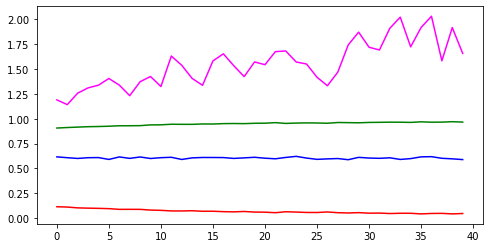

In [35]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.show()
